In [1]:
# EDA
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv('/content/creditcard.csv')

# Scale numerical features
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df[['Amount']])
df['scaled_time'] = scaler.fit_transform(df[['Time']])
df.drop(['Amount', 'Time'], axis=1, inplace=True)

# Split into features and target
X = df.drop('Class', axis=1).values
y = df['Class'].values

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(X_train.shape, X_test.shape)

(227845, 30) (56962, 30)


In [7]:
# Supervised Classifier - ANN
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model_dl = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_dl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['Precision', 'Recall', 'AUC']
)

history = model_dl.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50, batch_size=128,
    class_weight={0:1, 1:10},  # handle imbalance
    verbose=1
)


Epoch 1/50
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - AUC: 0.8964 - Precision: 0.3816 - Recall: 0.6270 - loss: 0.0555 - val_AUC: 0.9648 - val_Precision: 0.7545 - val_Recall: 0.8469 - val_loss: 0.0088
Epoch 2/50
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.9677 - Precision: 0.6938 - Recall: 0.8287 - loss: 0.0187 - val_AUC: 0.9600 - val_Precision: 0.7119 - val_Recall: 0.8571 - val_loss: 0.0062
Epoch 3/50
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.9559 - Precision: 0.6886 - Recall: 0.7985 - loss: 0.0200 - val_AUC: 0.9663 - val_Precision: 0.7714 - val_Recall: 0.8265 - val_loss: 0.0062
Epoch 4/50
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.9656 - Precision: 0.7225 - Recall: 0.8243 - loss: 0.0175 - val_AUC: 0.9620 - val_Precision: 0.7477 - val_Recall: 0.8469 - val_loss: 0.0048
Epoch 5/50
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.9865 - Precision: 0.6705 - Recall: 0.7985 - loss: 0.0156 - val_AUC: 0.9671 - val_Precision: 0.7083 - val_Recall: 0.8673 - val_lo

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
ROC-AUC: 0.9780676128076442
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.60      0.89      0.72        98

    accuracy                           1.00     56962
   macro avg       0.80      0.94      0.86     56962
weighted avg       1.00      1.00      1.00     56962



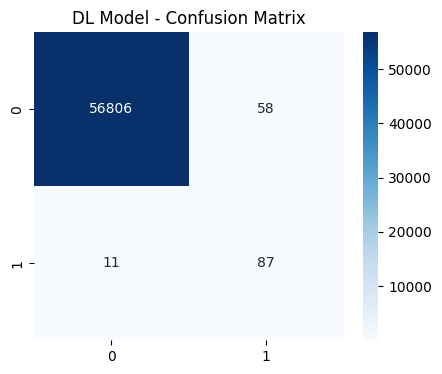

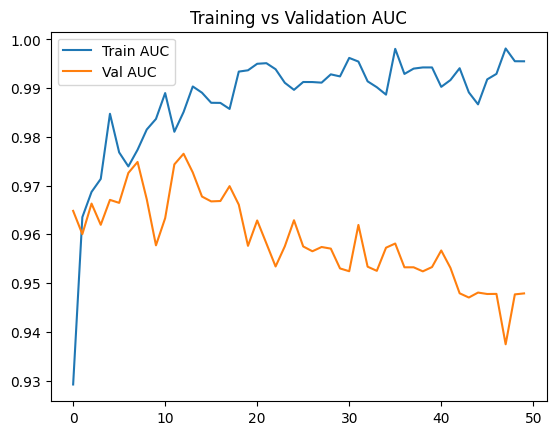

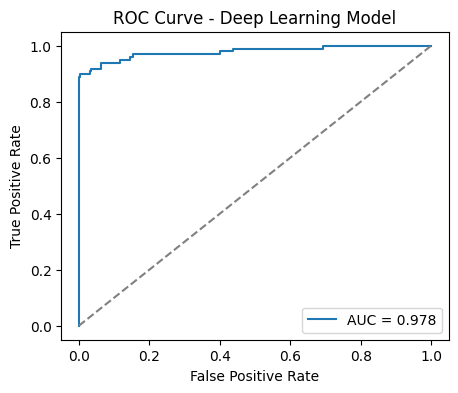

In [48]:
# Predictions
y_pred_prob = model_dl.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrics
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("DL Model - Confusion Matrix")
plt.show()

# Learning Curves
plt.plot(history.history['AUC'], label='Train AUC')
plt.plot(history.history['val_AUC'], label='Val AUC')
plt.title("Training vs Validation AUC")
plt.legend()
plt.show()

# ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_prob):.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve - Deep Learning Model")
plt.show()


In [12]:
model_dl.save("fraud_detection_dl_model.h5")

In [26]:
# Autoencoder (Unsupervised)
from tensorflow.keras import Model, Input

input_dim = X_train.shape[1]
encoding_dim = 16  # compressed latent space

input_layer = Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(
    X_train[y_train == 0], X_train[y_train == 0],
    epochs=40, batch_size=32, validation_split=0.1, verbose=1
)

Epoch 1/40
6398/6398 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.8836 - val_loss: 0.7417
Epoch 2/40
6398/6398 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.7612 - val_loss: 0.7333
Epoch 3/40
6398/6398 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.7537 - val_loss: 0.7302
Epoch 4/40
6398/6398 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.7433 - val_loss: 0.7270
Epoch 5/40
6398/6398 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.7309 - val_loss: 0.7254
Epoch 6/40
6398/6398 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.7384 - val_loss: 0.7244
Epoch 7/40
6398/6398 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.7339 - val_loss: 0.7238
Epoch 8/40
6398/6398 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.7341 - val_loss: 0.7230
Epoch 9/40
6398/6398 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.7270 - val_loss: 0.7225
Epoch 10/40
6398/6398 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.7352 - val_loss: 0.7223
Epoch 11/40
6398/6398 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.7277 - val_loss: 0.7223
Epoch 12/40
6398/63

In [27]:
encoder = Model(inputs=input_layer, outputs=encoded)
X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
print("Latent space shape:", X_train_latent.shape)

7121/7121 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 998us/step
Latent space shape: (227845, 16)


In [36]:
!pip -q install optuna xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 5.2 MB/s eta 0:00:00


In [38]:
# Hybrid Model with Optuna, XGBoost
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

def objective(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",         # or 'gpu_hist' if you have GPU
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 20),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1e-1, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1, log=True),
        "scale_pos_weight": (y_train==0).sum() / max(1, (y_train==1).sum()),
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
    }

    # 3-fold Stratified CV
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    aucs = []

    for tr_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[tr_idx], X_train[val_idx]
        y_tr, y_val = y_train[tr_idx], y_train[val_idx]

        model = xgb.XGBClassifier(**params, n_jobs=-1)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        preds = model.predict_proba(X_val)[:, 1]
        aucs.append(roc_auc_score(y_val, preds))

    return np.mean(aucs)


In [39]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, show_progress_bar=True)

[I 2025-10-24 03:46:31,903] A new study created in memory with name: no-name-6fc7a0f6-2144-4f49-976b-c7f6fefa68f2


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-24 03:47:07,014] Trial 0 finished with value: 0.9804218075158638 and parameters: {'learning_rate': 0.13184630431234706, 'max_depth': 9, 'min_child_weight': 6.498425652573921, 'subsample': 0.6783928075603352, 'colsample_bytree': 0.9496077896849224, 'gamma': 1.628203610419362, 'reg_alpha': 1.3630853038629858e-06, 'reg_lambda': 0.0004199720498839783, 'n_estimators': 243}. Best is trial 0 with value: 0.9804218075158638.
[I 2025-10-24 03:48:30,946] Trial 1 finished with value: 0.9811184175834765 and parameters: {'learning_rate': 0.07315284616080411, 'max_depth': 7, 'min_child_weight': 2.3639091618871073, 'subsample': 0.7629135722084193, 'colsample_bytree': 0.9785259836120264, 'gamma': 1.57861243941811, 'reg_alpha': 4.066138549891376e-07, 'reg_lambda': 5.616239309806228e-06, 'n_estimators': 759}. Best is trial 1 with value: 0.9811184175834765.
[I 2025-10-24 03:49:21,471] Trial 2 finished with value: 0.9786476058154538 and parameters: {'learning_rate': 0.28482353221112133, 'max_dep

In [42]:
best_params = study.best_params
best_params.update({
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "tree_method": "hist",
    "n_jobs": -1,
    "random_state": 42
})

print("Best Parameters:", best_params)

model_xgb = xgb.XGBClassifier(**best_params)
model_xgb.fit(X_train, y_train)

y_pred_prob = model_xgb.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob > 0.5).astype(int)

print("Optuna-XGBoost ROC-AUC:", roc_auc_score(y_test, y_pred_prob))


Best Parameters: {'learning_rate': 0.039443296107166376, 'max_depth': 5, 'min_child_weight': 13.519388397657206, 'subsample': 0.6054186480758742, 'colsample_bytree': 0.502361555201489, 'gamma': 2.8761637621394462, 'reg_alpha': 9.953142129016705e-07, 'reg_lambda': 0.006600724271138251, 'n_estimators': 558, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'hist', 'n_jobs': -1, 'random_state': 42}
Optuna-XGBoost ROC-AUC: 0.9737431164080714


In [49]:
import pandas as pd

results = pd.DataFrame({
    'Model': ['Deep Neural Network', 'Autoencoder + XGBoost'],
    'ROC-AUC': [
        roc_auc_score(y_test, y_pred_prob),
        roc_auc_score(y_test, y_pred_prob_xgb)
    ]
})

display(results)


,Model,ROC-AUC
0,Deep Neural Network,0.978068
1,Autoencoder + XGBoost,0.977776


In [60]:
import joblib
import tensorflow as tf

# Save models
encoder.save("fraud_autoencoder.h5")
joblib.dump(model_xgb, "fraud_xgb.pkl")

# Create a metadata bundle
bundle = {
    "autoencoder_path": "fraud_autoencoder.h5",
    "xgb_model_path": "fraud_xgb.pkl"
}

# Save the bundle
joblib.dump(bundle, "fraud_hybrid_model.pkl")
print("Autoencoder, XGBoost, and bundle saved successfully!")

Autoencoder, XGBoost, and bundle saved successfully!
